In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import bisect

In [2]:
# process with change-point at the moment nu


def arp_cp(n, theta1, theta2, nu, b1, b2):
    x = np.random.normal(0,b1,len(theta1))
    for i in range(nu-1):
        x = np.append(x,(np.sum(theta1*x[-1:-(len(theta1)+1):-1])+np.random.normal(0,b1,1)))
    for i in range(nu, n):
        x = np.append(x,(np.sum(theta2*x[-1:-(len(theta1)+1):-1])+np.random.normal(0,b2,1)))
    return x

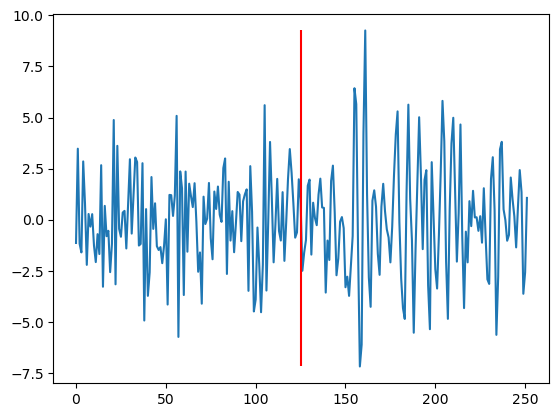

In [4]:
# realisation of the process with change-point
# blue line is AR(p) process with disruption
# red line is change-point


theta1 = np.array([-0.19387679, -0.1028479 ,  0.14383122])
theta2 = np.array([ 0.36849868, -0.45574945, -0.37076795])
h = 6
b1 = 2
b2 = b1
n = 250
nu = int(n / 2)

ar_p =  arp_cp(n, theta1, theta2, nu, b1, b2)

plt.plot(ar_p)
plt.vlines(nu, np.min(ar_p), np.max(ar_p), color = 'r')

In [5]:
# LSE estimator

def LSE(x,p):
    num=0
    den=0
    for i in range(p+1,len(x)):
        var = np.reshape(x[i-1:i-p-1:-1],(p,1))
        num += var * x[i]
        den += var @ var.transpose()
    den = np.linalg.inv(den)
    return ((den @ num).reshape(1,p)[0])

In [6]:
#estimator of the parameter theta on the interval

def seq_est(h, theta1, X_init, n1, n2, b1):
    p = len(theta1)
    x = np.array(X_init)
    
    obs_l = lambda x, theta, b1: np.sum(theta * x[-1:-p-1:-1])+np.random.normal(0,b1,1)
    
    ############################## Pilot estimate of the parameter \theta
    for i in range(n1):
        obs = obs_l(x, theta1, b1)
        x = np.append(x, obs)
    theta_est = LSE(x,p)
    
    ############################## Estimate of the npose variance \Gamma
    Sn1n2 = 0
    for i in range(n2):
        obs = obs_l(x, theta1, b1)
        x = np.append(x, obs)
        Sn1n2 += (x[-1] - np.sum(theta_est * x[- 2 : - 2 - p : -1])) ** 2
    Gamma = 1 / (n2 - 2) * Sn1n2
    
    ############################## Initial values of the coefficients \nu_k
    A = np.zeros((p,p))
    B = np.zeros((p,1))
    obs = obs_l(x, theta1, b1)
    x = np.append(x, obs)
    
    X_past = x[-2:-p-2:-1]
    lin_ind_vec = [X_past]
    while abs(np.linalg.det(A)) < 10 ** (-4):
        obs = obs_l(x, theta1, b1)
        x = np.append(x, obs)
        
        ########################## Check linear independance
        X_past = x[-2:-p-2:-1]
        lin_ind_vec.append(X_past)
        k = 0
        for i in range(len(lin_ind_vec)-1):
            test_vec_li = lin_ind_vec[i] / lin_ind_vec[-1]
            for j in range(p-1):
                if(abs(test_vec_li[j]-test_vec_li[j+1]) > 10 ** (-4)):
                    k += 1
                    break
        if k == (len(lin_ind_vec)-1):
            if(k == p):
                break
            nu = (Gamma * np.sum(X_past ** 2)) ** (-1/2)
        else:
            nu = 0
        A += nu * X_past.reshape(p,1) @ X_past.reshape(1,p)
        B += nu * X_past.reshape(p,1) * x[-1]
         
    ############################## Stage of the calculating of the sequential estimate
    min_lam = 0
    sum_nu2X2 = 0
    Nu=[]
    A1 = np.zeros((p,p))
    B1 = np.zeros((p,1))
    while min_lam < h:
        obs = obs_l(x, theta1, b1)
        x = np.append(x, obs)
        X_past = x[-2:-p-2:-1]
        A_add = X_past.reshape(p,1) @ X_past.reshape(1,p)
        norm2_X_past = np.linalg.norm(X_past) ** 2
        eq = lambda z: float(np.min(np.linalg.eigvals(A + z * A_add)) / Gamma - float(sum_nu2X2 + z**2 * norm2_X_past))

        ########################## Handling of the error of calculating
        try:
            nu = bisect(f = eq, a = 10 ** (-10), b = 1/Gamma, args = ())
        except ValueError:
            nu = 0
        Nu.append([eq(0), eq(nu), eq(1/Gamma), nu, 1/Gamma])
        A += nu * A_add
        B += nu * X_past.reshape(p,1) * x[-1]
        sum_nu2X2 += nu**2 * norm2_X_past
        min_lam = float(np.min(np.linalg.eigvals(A)))
    
    ############################## Recalculating last coefficient \nu_\tau
    eq_past = lambda z: float(np.min(np.linalg.eigvals(A + (z - nu) * A_add))) - h
    try:
        nu_past = bisect(f = eq_past, a = 10 ** (-10), b = nu, args = ())
    except ValueError:
        nu_past = 0
    A += (nu_past - nu) * A_add
    B += (nu_past - nu) * X_past.reshape(p,1) * x[-1]

    #df = pd.DataFrame(Nu, columns=('eq_zero','eq_nu', 'eq_term', 'nu', 'Gamma_inv'))
    
    ############################## Throwing initial values of the process
    x = x[p:]
    est = np.linalg.inv(A) @ B
    return([est.reshape(1,p), x])
    
    

In [7]:
def seq_estimates_before(N, h, theta1, n1, n2, b1):
    X_init = np.random.normal(0, b1, len(theta1)) 
    p = len(theta1)
    est = []
    for i in range(N):
        res = seq_est(h, theta1, X_init, n1, n2, b1)
        X_init = res[1][-1:-p-1:-1]
        t = len(res[1])
        MSE = np.linalg.norm(res[0] - theta1) ** 2
        samp = np.append(res[0].reshape(1,p),(t, MSE))
        est.append(samp)
    col_names = [f'theta{i}' for i in range(1,p+1)]
    col_names.extend(['samp_size', 'MSE'])
    df = pd.DataFrame(est, columns = col_names)
    return(df)

In [8]:
# Consider AR(2) process with parameter theta = (-0.9,-0.3)'

N = 1000
h = 1
theta1 = np.array([-0.9,-0.3])
n1 = 20 
n2 = 20 
b1 = 1.5

seq_est_before = seq_estimates_before(N, h, theta1, n1, n2, b1)
seq_est_before

# Here we can see sequence of sequential estimaes of parameter theta = (theta1, theta2)
# which constructed on the sample with sample size is equal to samp_size
# MSE is sample mean square error of the estimate theta = (theta1, theta2).

,theta1,theta2,samp_size,MSE
0,-0.159976,0.044485,47.0,0.666306
1,-0.891357,0.322537,46.0,0.387627
2,-2.513997,-1.314413,45.0,3.634020
3,-0.873371,-1.408347,44.0,1.229142
4,-1.087992,-0.801421,55.0,0.286764
...,...,...,...,...
995,-1.583701,-2.185091,46.0,4.021014
996,-0.056574,0.590935,49.0,1.505133
997,-1.217480,-0.701865,51.0,0.262290
998,-1.754687,-1.083549,50.0,1.344439


In [9]:
seq_est_before.describe()

# Here aggregation of previous table 

,theta1,theta2,samp_size,MSE
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.893044,-0.319154,48.637000,0.703557
std,0.606582,0.579572,3.571272,0.951662
min,-3.008687,-2.288208,44.000000,0.000615
25%,-1.275691,-0.677112,46.000000,0.132731
50%,-0.887446,-0.333213,48.000000,0.349589
75%,-0.539049,0.035405,51.000000,0.905314
max,1.981245,1.636950,65.000000,8.307278


In [9]:
def parameters(theta1, theta2, b1, b2, n_obs, nu):
    if(n_obs < nu):
        return([theta1, b1])
    else:
        return([theta2, b2])
        

In [10]:
def seq_est_disr(h, theta1, theta2, X_init, n1, n2, b1, b2, nu_disr, x_len_past):
    p = len(theta1)
    x = np.array(X_init)
    
    n_obs = x_len_past
    obs_l = lambda x, par: np.sum(par[0] * x[-1:-p-1:-1])+np.random.normal(0,par[1],1)
    
    ############################## Pilot estimate of the parameter \theta
    for i in range(n1):
        n_obs += 1
        par = parameters(theta1, theta2, b1, b2, n_obs, nu_disr)
        obs = obs_l(x, par)
        x = np.append(x, obs)
    theta_est = LSE(x,p)
    
    ############################## Estimate of the npose variance \Gamma
    
    delta = p ** (1/2) * 0.25
    norm_pil_est = 2 * delta
    theta_est_test = theta_est
        ########################## Check of closeness of pilot estimates
    while(norm_pil_est > delta):
        theta_est = theta_est_test
        for i in range(n2):
            n_obs += 1
            par = parameters(theta1, theta2, b1, b2, n_obs, nu_disr)
            obs = obs_l(x, par)
            x = np.append(x, obs)
        theta_est_test = LSE(x[-n2:],p)
        norm_pil_est = np.linalg.norm(theta_est-theta_est_test)

    Sn1n2 = 0
    for i in range(n2):
        Sn1n2 += (x[-i-1] - np.sum(theta_est * x[- i - 2 : -i - 2 - p : -1])) ** 2
    Gamma = 1 / (n2 - 2) * Sn1n2
    
    ############################## Initial values of the coefficients \nu_k
    A = np.zeros((p,p))
    B = np.zeros((p,1))
    n_obs += 1
    par = parameters(theta1, theta2, b1, b2, n_obs, nu_disr)
    obs = obs_l(x, par)
    x = np.append(x, obs)
    
    X_past = x[-2:-p-2:-1]
    lin_ind_vec = [X_past]
    while abs(np.linalg.det(A)) < 10 ** (-4):
        n_obs += 1
        par = parameters(theta1, theta2, b1, b2, n_obs, nu_disr)
        obs = obs_l(x, par)
        x = np.append(x, obs)
        
        ########################## Check linear independance
        X_past = x[-2:-p-2:-1]
        lin_ind_vec.append(X_past)
        k = 0
        for i in range(len(lin_ind_vec)-1):
            test_vec_li = lin_ind_vec[i] / lin_ind_vec[-1]
            for j in range(p-1):
                if(abs(test_vec_li[j]-test_vec_li[j+1]) > 10 ** (-4)):
                    k += 1
                    break
        if(k == (len(lin_ind_vec)-1)):
            nu = (Gamma * np.sum(X_past ** 2)) ** (-1/2)
        else:
            nu = 0
        A += nu * X_past.reshape(p,1) @ X_past.reshape(1,p)
        B += nu * X_past.reshape(p,1) * x[-1]
    A -= nu * X_past.reshape(p,1) @ X_past.reshape(1,p)
    B -= nu * X_past.reshape(p,1) * x[-1]
         
    ############################## Stage of the calculating of the sequential estimate
    min_lam = float(np.min(np.linalg.eigvals(A)))
    sum_nu2X2 = 0
#     A1 = np.zeros((p,p))
#     B1 = np.zeros((p,1))
    while min_lam < h:
        X_past = x[-2:-p-2:-1]
        A_add = X_past.reshape(p,1) @ X_past.reshape(1,p)
        norm2_X_past = np.linalg.norm(X_past) ** 2
        eq = lambda z: float(np.min(np.linalg.eigvals(A + z * A_add)) / Gamma - float(sum_nu2X2 + z**2 * norm2_X_past))

        ########################## Handling of the error of calculating
        try:
            T = 0
            nu = bisect(f = eq, a = 10 ** (-10), b = 1/Gamma, args = ())
        except ValueError:
            T += 1
            if(T == 200):
                break
            nu = 0
        A += nu * A_add
        B += nu * X_past.reshape(p,1) * x[-1]
        sum_nu2X2 += nu**2 * norm2_X_past
        min_lam = float(np.min(np.linalg.eigvals(A)))
        if(min_lam >= h):
            break
        n_obs += 1
        par = parameters(theta1, theta2, b1, b2, n_obs, nu_disr)
        obs = obs_l(x, par)
        x = np.append(x, obs)
    
    ############################## Recalculating last coefficient \nu_\tau
    eq_past = lambda z: float(np.min(np.linalg.eigvals(A + (z - nu) * A_add))) - h
    try:
        nu_past = bisect(f = eq_past, a = 10 ** (-10), b = nu, args = ())
    except ValueError:
        nu_past = 0
    A += (nu_past - nu) * A_add
    B += (nu_past - nu) * X_past.reshape(p,1) * x[-1]
    
    ############################## Throwing initial values of the process
    x = x[p:]
    est = np.linalg.inv(A) @ B
    return([est.reshape(1,p), x])
    
    

In [11]:
# realisation of CUSUM procedure

def CUSUM_N(N, h, theta1, theta2, n1, n2, b1, b2, nu):
    p = len(theta1)
    k = 0

    ############################## Inititializing of first estimate of the parameter before a change-point
    X_init = np.random.normal(0, b1, len(theta1)) 
    res = seq_est(h, theta1, X_init, n1, n2, b1)
    
    X = res[1]
    x_len_past = len(res[1])
    nu_disr = nu
    X_init = res[1][-1:-p-1:-1]
    theta0_est = res[0] 
    T_n = []
    sum_stat = 0

    ############################## Calculating of the sequence of sequentiak estimates and base statistics
    while(x_len_past < 2 * nu_disr):
        res = seq_est_disr(h, theta1, theta2, X_init, n1, n2, b1, b2, nu_disr, x_len_past)
        X = np.append(X, res[1])
        X_init = res[1][-1:-p-1:-1]
        theta1_est = res[0]
        samp_size = len(res[1])
        x_len_past += samp_size
        base_stat = np.linalg.norm(theta0_est - theta1_est) - 2 / h * (h + p - 1) ** 0.5
        sum_stat = np.max([sum_stat + base_stat, 0])
        T_n.append([sum_stat, x_len_past])
        if(x_len_past >= nu_disr):
            k += 1
    return [X, nu_disr, T_n]


In [12]:
theta1 = np.array([-0.19387679, -0.1028479 ,  0.14383122])
theta2 = np.array([ 0.36849868, -0.45574945, -0.37076795])
L = np.linalg.norm(theta1 - theta2)
h = 4 * L ** (-2) * (2 + (4 + L ** 2 * (len(theta1) - 1)) ** 0.5)
b1 = 2
b2 = 1.4
n1 = 20 
n2 = 20 
nu = 4000


z = CUSUM_N(N, h, theta1, theta2, n1, n2, b1, b2, nu)


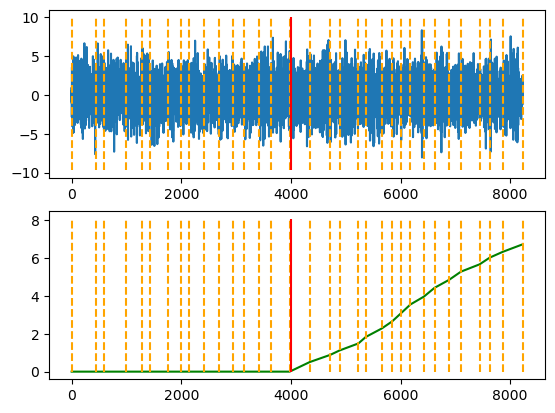

In [13]:
temp = np.transpose(np.array(z[2]))
Z_k = np.insert(temp[0], 0, 0)
tau = np.insert(temp[1], 0, 0)
plt.subplot(2, 1, 1)
plt.plot(z[0])
plt.vlines(tau, -1.2*abs(np.min(z[0])), 1.2*abs(np.max(z[0])), color = 'orange', linestyle = '--')
plt.vlines(z[1], -1.2*abs(np.min(z[0])), 1.2*abs(np.max(z[0])), color = 'r')

plt.subplot(2, 1, 2)
plt.plot(tau, Z_k , color = 'g')
plt.vlines(tau, 0, 1.2*abs(np.max(Z_k)), color = 'orange', linestyle = '--')
plt.vlines(z[1], 0, 1.2*abs(np.max(Z_k)), color = 'r')

In [14]:
# on the top sublot we can see AR(3) process with change-point (blue line) at the moment 4000 (vertical red line)
# vertical dashed orange lines are stopping moments tau_i 
# At the lower subplot there are sequense of base statistics of CUSUM procedure (green line)  

# After the change-point sequense of base statistics start increasing by the linear trend
